# 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle
import sys
import tempfile
sys.path.append("scripts/")

from AnnotateTree import AnnotateTree
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqIO import index as fasta_index, parse, write
from Bio.SeqRecord import SeqRecord
from Bio.SubsMat import MatrixInfo as matlist
from CRISPRtools import BLAST, MakeFasta, PilerCRReader, MinCEDReader
from glob import glob
from easyFunctions import Coordinate
from os import chdir, path, stat, system
from random import randint

################################         Data          ################################
chdir("/mnt/research/germs/shane/transActRNA/data")
casRelatedAssemblies={}
for rec in parse(open("CasRelatedAssemblies.fasta","rb"),"fasta"):casRelatedAssemblies[rec.id]=str(rec.seq)
allCas9s = fasta_index("Cas9-Like-clustered.faa", "fasta")
print "Number of Cas9s:", len(allCas9s)

################################    Custom Methods     ################################
r = lambda: randint(0,255)            
def color():return '#%02X%02X%02X' % (r(),r(),r())

def WriteSequence(tmpFasta,index,seq,rec):
    index+=1
    tmpFasta.write(">Seq_%i_%i_%i\n%s\n" % (min(rec.start,rec.end),max(rec.start,rec.end),index,seq[min(rec.start,rec.end):max(rec.start,rec.end)+500]))
    index+=1
    tmpFasta.write(">Seq_%i_%i_%i\n%s\n" % (min(rec.start,rec.end),max(rec.start,rec.end),index,seq[min(rec.start,rec.end)-500:max(rec.start,rec.end)]))
    return index


################################ Custom Data Structures ################################
class ErpinOut:
    def __init__(self, outfile="tmp/rhoInd.out", inputfile="tmp/possibleTracrs.fasta"):
        self.numRecords = 0
        self.terminators = []
        self.records={}
        with open(inputfile) as file:
            for rec in parse(file,"fasta"):
                self.numRecords += 1
                self.records[rec.id]=str(rec.seq)
        with open(outfile) as file:
            for i in range(9): file.readline()
            capture = False
            for line in file:
                if capture: 
                    line = line.strip().replace("  "," ").replace("  "," ").replace("  "," ")
                    self.terminators.append(RhoIndTerminator(seqName,line.split(" ")))
                capture = (">" in line)
                if capture: seqName = line.strip().replace(">","")
class RhoIndTerminator:
    def __init__(self,name,info):
        self.name = name
        self.strand = (info[0]=="FW")
        start,end = info[2].split("..")
        self.Rholocation = Coordinate(start,end)
        self.fwd = int(self.name[-1]) % 2 != 0
    def __str__(self): return "%s\t%s\t%s\t%s\t" % (self.name,str(self.strand),str(self.Rholocation),str(self.fwd))
    
################################ Custom Functions ################################
matrix = matlist.blosum62
gap_open = -8
gap_extend = -.8

def RC(seq): return str(Seq(seq).reverse_complement())
def scoreAlign(alignment):
    ref, frag, score, begin, end = alignment
    matches = 0
    for pos in range(len(ref)):
        if ref[pos] == frag[pos]:matches+=1
    return matches/float(len(frag.replace("-","")))         
def scoreAligns(aln1,aln2):
    score1, score2 = scoreAlign(aln1), scoreAlign(aln2)
    if score1 > score2: return aln1,score1*100
    else: return aln2, score2*100   
    
def alignSequences(refSeq,fragment):
    try: aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    except: aln1 = None
    try: aln2 = pairwise2.align.globalds(refSeq, RC(fragment), matrix, gap_open, gap_extend)[0]
    except: aln2 = None
    if aln1 == None and aln2 == None: return None,0
    elif aln1 == None: top_aln = aln2
    elif aln2 == None: top_aln = aln1
    else: top_aln,alnScore = scoreAligns(aln1,aln2)
    if alnScore == None: alnScore = 0    
    if top_aln == None:print "Here"
    aln_probe, aln_arms, score, begin, end = top_aln
    return alnScore

def alignSequence(refSeq,fragment):
    aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    try: aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    except: aln1 = None
    try: aln2 = pairwise2.align.globalds(refSeq, RC(fragment), matrix, gap_open, gap_extend)[0]
    except: aln2 = None
    if aln1 == None and aln2 == None: return None,0
    elif aln1 == None: top_aln = aln2
    elif aln2 == None: top_aln = aln1
    else: top_aln,alnScore = scoreAligns(aln1,aln2)
    if alnScore == None: alnScore = 0    
    if top_aln == None:print "Here"
    aln_probe, aln_arms, score, begin, end = top_aln
    return '%s\t%% Matching %.2f%%\n\t%s' % (aln_probe, alnScore, aln_arms), alnScore

Number of Cas9s: 2023


### Run CRISPR predictions to find CRISPR arrays in the genomic assemblies where Cas9s were found

In [2]:
outdir = "crisprs"
assembly_dir = "assemblies/"
assemblies = glob.glob(assembly_dir+"*.fa")
print "Number of assemblie to run CRISPR array detection on:",len(assemblies)
for assembly in assemblies:

    #Run PilerCR
    if path.exists("%s/%s.pcrout" % (outdir, assembly)):retCode1 = 0
    else: retCode1 = system("pilercr -minid 0.85 -mincons 0.8 -minarray 3 -noinfo -in %s -out %s/%s.pcrout" %(assembly_dir+assembly, outdir, assembly))
        
    #Run minced
    if path.exists("%s/%s.pcrout" % (outdir, assembly)):retCode2 = 32512
    else: retCode2 = system("minced -maxSL 75 --maxRL 75 -minRL 16 -minSL 20 -searchWL 6 %s %s/%s.mnout" % (assembly_dir+assembly, outdir, assembly))
    
    if retCode1 != 0: 
        print "%i\npilercr -minid 0.85 -mincons 0.8 -minarray 3 -noinfo -in %s -out %s/%s.pcrout" %(retCode1,assembly_dir+assembly, outdir, assembly)
        break
    if retCode2 != 32512: 
        print "%i\nminced -maxSL 75 --maxRL 75 -minRL 16 -minSL 20 -searchWL 6 %s %s/%s.mnout" % (retCode2,assembly_dir+assembly, outdir, assembly)
        break

Number of assemblie to run CRISPR array detection on: 2670


### Read and store the results

In [3]:
minCED_results, pilerCR_results = {},{}
crisprs_in_both, crisprs_only_in_piler, crisprs_only_in_minced, no_results, counter = 0, 0, 0, 0, 0
crisprResultFiles = glob("crisprs/*.pcrout")
noCRISPR = set()
for pilerCRFileName in crisprResultFiles:
    protID = pilerCRFileName.replace(".fasta.pcrout","").replace("crisprs/","")
    mincedFileName = pilerCRFileName.replace("pcrout","mnout")
    noMinced = (stat(mincedFileName).st_size == 0)
    noPiler = (stat(pilerCRFileName).st_size <= 200)
    
    if not noMinced and not noPiler:
        crisprs_in_both +=1
        minCED_results[protID]  = MinCEDReader(mincedFileName)
        pilerCR_results[protID] = PilerCRReader(pilerCRFileName)
        minCED_results[protID].calulate_consensus_seqs()
#         for id,locus in pilercrResults.iteritems():
#             if id in mincedResults:
# #                     mincedResults[id].combineResults(locus)
    elif not noMinced:
        crisprs_only_in_minced += 1
        minCED_results[protID]  = MinCEDReader(mincedFileName)
        minCED_results[protID].calulate_consensus_seqs()
    elif not noPiler:
        crisprs_only_in_piler += 1
        pilerCR_results[protID] = PilerCRReader(pilerCRFileName)
    else:
        no_results += 1
        noCRISPR.add(protID)
        #Remove files to ensure integrity of data
        #os.system("rm -f %s %s" % (mincedFileName, pilerCRFileName ))  #TODO Delete this after have run once

crisprsFound = crisprs_in_both + crisprs_only_in_minced + crisprs_only_in_piler
print "Found %i crisprs in %s assemblies" % (crisprsFound,crisprsFound+no_results)
print "\tBoth:", crisprs_in_both
print "\tMinced only:", crisprs_only_in_minced
print "\tPiler only:", crisprs_only_in_piler
print "\tNo CRISPR:",no_results
pickle.dump(minCED_results,open("pickles/MinCED_CRISPRS.p","wb"))
pickle.dump(pilerCR_results,open("pickles/PilerCR_CRISPRS.p","wb"))
pickle.dump(noCRISPR,open("pickles/noCRISPRS.p","wb"))

Found 1458 crisprs in 2023 assemblies
	Both: 1322
	Minced only: 116
	Piler only: 20
	No CRISPR: 565


In [2]:
minCED_results = pickle.load(open("pickles/MinCED_CRISPRS.p","rb"))
pilerCR_results = pickle.load(open("pickles/PilerCR_CRISPRS.p","rb"))

### BLAST for the consensus repeat, annotate the genome with NR, narrow down the possible tracr solutions to array terminal and extra array hits

In [27]:
from easyFunctions import Coordinate
crRNALens, crisprLocations, noPredictedTracr, seqLenDist = [],[],[],[]
crRNALens, possibleSolutions, newSolutions, index, counter = [], set(), {}, 0, 0
nCounter, n_and_no_possibles = 0,0
for protID in allCas9s:
    if protID not in pilerCR_results and protID not in minCED_results: continue #Missing from both
    try: 
        assemblyLoci = pilerCR_results[protID].values() #Looking only at the most abundant crispr
        for locus in assemblyLoci:
            if locus.name == protID: break
        if locus.name == protID: print "HELO"; die
    except: 
        for locus in assemblyLoci:
            if locus.name == protID: break
        if locus.name == protID: print "SDFSDG" ; die
        #locus = minCED_results[protID].values()[0]
    print protID
    write([SeqRecord(id=protID,description='',seq=Seq(locus.consensusRepeat[0]))],"tmp/consFasta.fa","fasta")
    blast_results = BLAST("tmp/consFasta.fa", "assemblies/%s.fa" % (protID), "tmp/consBlast.xml")
    
    #Step 2b
    boundaryHits,crRNALen = locus.checkArrayBoundaries(blast_results)
    crRNALens.append(crRNALen)
    locus.annotate(casRelatedAssemblies[protID], "assemblies/%s.fa" % (protID))
    if locus.hasNRegion: nCounter += 1
    
    #Step 2c
    tmpFasta = open("tmp/possibleTracrs.fasta","w")
    
    ##Step 2d
    terminusSeqs, index = locus.getTerminusRepeats(casRelatedAssemblies[protID],index)
    tmpFasta.write(terminusSeqs)
    
    #Collect some stats
    startCoord = locus.repeatCoords[0]
    endCoord = locus.repeatCoords[-1]
    seqlen = len(casRelatedAssemblies[protID])
    seqLenDist.append(seqlen)
    minDist = min(seqlen-startCoord.start,seqlen-startCoord.end,seqlen-endCoord.start,seqlen-endCoord.end)
    minDist =  min(minDist,startCoord.start,startCoord.end,endCoord.start,endCoord.end)
    crisprLocations.append(minDist)

    ##Step 2e
    for rec in boundaryHits: index = WriteSequence(tmpFasta,index,casRelatedAssemblies[protID],rec)
    
    ##Step 2f
    tmpFasta.close()
    cmd = "~/bin/Arnold/erpin ~/bin/Arnold/rho-indep.epn tmp/possibleTracrs.fasta -1,4 -add 1 4 2 -pcw 1 -cutoff 100% >tmp/rhoInd.out"
    system(cmd)
    
    ##Setp 2j
    erpOut = ErpinOut()
    if len(erpOut.terminators)==0: 
        print "\nThis ref has nothing: %s\n" % protID
        noPredictedTracr.append(protID)
        if locus.hasNRegion: n_and_no_possibles +=1
    else: 
        newSolutions[protID] = erpOut
        repeatIndex = 0
    
    ##Look through terminators
    for terminator in erpOut.terminators:
        info= terminator.name.split("_")
        whereRepeat = (info[1] == "S")
        start = int(info[-3])
        end = int(info[-2])
        strand = -1
        if terminator.strand == "+": strand = 1
        if whereRepeat: 
            tracr_size = end - (end-min(terminator.Rholocation.start, terminator.Rholocation.end))
            if tracr_size > 300:continue
            repeatFeature = SeqFeature(FeatureLocation(end-min(terminator.Rholocation.start, terminator.Rholocation.end), end), type="CDS", strand=strand)
        else: 
            tracr_size = (start + max(terminator.Rholocation.start, terminator.Rholocation.end)) - start
            if tracr_size > 300:continue
            repeatFeature = SeqFeature(FeatureLocation(start,start + max(terminator.Rholocation.start, terminator.Rholocation.end)), type="CDS", strand=strand)
        fid = "Theoretical tracrRNA_%i" % (repeatIndex)
        repeatFeature.qualifiers['label'] = [fid]
        locus.orfs.records[protID].features.append(repeatFeature)
        repeatIndex += 1 
    
    #shift annoations by buffer
    if not locus.orfs:continue
    locus.orfs.records[protID].seq = locus.orfs.records[protID].seq[max(locus.min-500,0):locus.max+500]
    for rec in locus.orfs.records[protID].features:
#         print "This is the start:", rec.location.start - max(locus.min-100,0), rec.location.end - max(locus.min-100,0),rec.location.start,rec.location.end
        rec.location = FeatureLocation(rec.location.start - max(locus.min-500,0), rec.location.end - max(locus.min-500,0))
#         print "This is the   end:", rec.location.start, rec.location.end
    
    # Step 2k Create setup for GB file for Vector NTI
    for id in locus.orfs.records:
        print "data/annotations/%s.gb" % (locus.name)
        fh = open("data/annotations/%s.gb" % (locus.name),"w")
        biopythonID = id[:id.find(":")-1] #Biopython limits genbank file ids to 16 characters
        locus.orfs.records[id].id = biopythonID[:16]
        locus.orfs.records[id].name = biopythonID[:16]
        write([locus.orfs.records[id]],fh,'genbank')
        fh.close()
    
pickle.dump(newSolutions,open("pickles/NewSolutions.p","wb"))
print "\n\nNumber of proteins with large N region and no terminator / with total large N region: %i / %i" % (n_and_no_possibles,nCounter)
print "%i possible solutions in %s references. Nothing found in %i references" % (index-1, len(newSolutions),len(noPredictedTracr))

NZ_NDGA01000017.1_ORF1
NZ_NDGA01000017.1 CRISPR Array: [120974	121257]
	Average spacer len: 31 + Repeat len: 36 = 67 basepairs
	Before:
		[114772	114797] False
	After:
		[120974	121010] Within
		[121040	121076] Within
		[121105	121141] Within
		[121171	121207] Within
		[121236	121257] Within

	Updated CRISPR Array: [120974	121257]
	Possible TRACRS:
		[120974	121010]
		[121236	121257]
		[114772	114797]

!File exists /mnt/research/germs/shane/transActRNA/data/annotations/blast/NZ_NDGA01000017.1_orfs.blastout
BEXE01000012_ORF1
BEXE01000012 CRISPR Array: [23369	24740]
	Average spacer len: 30 + Repeat len: 36 = 66 basepairs
	Before:
	After:
		[23369	23403] Within
		[23451	23486] Within
		[23516	23552] Within
		[23582	23618] Within
		[23648	23684] Within
		[23714	23750] Within
		[23780	23816] Within
		[23846	23882] Within
		[23912	23948] Within
		[23978	24014] Within
		[24044	24080] Within
		[24110	24146] Within
		[24176	24212] Within
		[24242	24278] Within
		[24308	24344] Within
		[24374	24

AttributeError: 'NoneType' object has no attribute 'records'

In [17]:
locus = pilerCR_results["NZ_NDGA01000017.1_ORF1"].values()

for val in locus:
    print val,

NZ_NDGA01000024.1	1	409	['TTTCAATCCACGCACCCGCAAAGGGTGCGAC']	crRNAs:7
 NZ_NDGA01000011.1	43	180	['GTCGCCCCCTTTGCGGGTGCGTGGATTGAAATT']	crRNAs:3
 NZ_NDGA01000018.1	42	186	['GTTTTAGAGCTGTGCTGTTTCGAATGGTTCCAAAAC']	crRNAs:3
 NZ_NDGA01000017.1	120975	121184	['GTTTTAGAGCTGTGCTGTTTCGAATGGTTCCAAAAC']	crRNAs:4



In [10]:
locus.annotate(casRelatedAssemblies["NZ_NDGA01000017.1_ORF1"], "assemblies/%s.fa" % ("NZ_NDGA01000017.1_ORF1"))

!File exists /mnt/research/germs/shane/transActRNA/data/annotations/blast/NZ_NDGA01000024.1_orfs.blastout


In [4]:
numPos, numTerminators, tracrSeqDict = {}, {}, {}
newSolutions = pickle.load(open("pickles/NewSolutions.p","rb"))
index = 0
sizeDist = []
possibleSol = open("PredictedTracrRNAs.fa","w")
for ref,psol in newSolutions.iteritems():
    if ref not in allCas9s:continue
    for terminator in psol.terminators:
        seq = psol.records[terminator.name]
        solSize = 0
        if terminator.fwd: 
            solSize = terminator.Rholocation.end
            tracrSeq = seq[:solSize].upper()
        else: 
            solSize = len(seq) - terminator.Rholocation.start-1
            tracrSeq = seq[terminator.Rholocation.start-1:].upper()
        sizeDist.append(solSize)
        if solSize>350 or tracrSeq.count("N")>=4:continue
        index += 1
        tracrSeqDict["%s_%i" % (ref,index)] = tracrSeq
        possibleSol.write(">%s_%i\n%s\n" % (ref,index,tracrSeq))

possibleSol.close()
print "Done", index, "possible solutions"

Done 5023 possible solutions


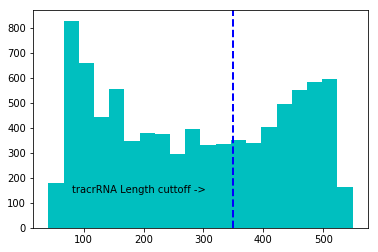

count    8605.000000
mean      287.988146
std       151.275039
min        41.000000
25%       144.000000
50%       283.000000
75%       434.000000
max       549.000000
dtype: float64


In [5]:
from pandas import Series
from matplotlib import pyplot as plt
ser = Series(sizeDist)
plt.hist(ser,bins=20, color='c')
plt.axvline(350, color='b', linestyle='dashed', linewidth=2)
plt.text(80,140,'tracrRNA Length cuttoff ->')
plt.show()
print ser.describe()

count    1740.000000
mean       67.800575
std         9.689599
min        41.000000
25%        65.000000
50%        66.000000
75%        72.000000
max       118.000000
dtype: float64


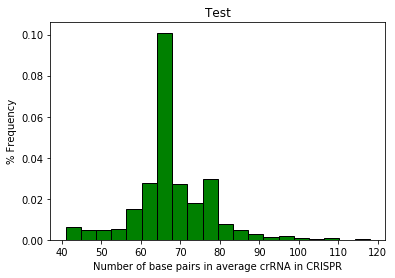

In [6]:
ser = Series(crRNALens)
ser = ser [ser > 40]
ax = ser.plot.hist(bins=20,title="Test",normed=True,color='g',edgecolor="k") #,grid=True)
ax.set_xlabel("Number of base pairs in average crRNA in CRISPR")
ax.set_ylabel("% Frequency")
ax
print ser.describe()

In [7]:
%%bash
cd-hit-est -i PredictedTracrRNAs.fa -o PredictedTracrRNAs.grouped.fasta -M 0 -d 0 -c .85 -T 0

Program: CD-HIT, V4.7 (+OpenMP), Jul 11 2017, 18:04:58
Command: cd-hit-est -i PredictedTracrRNAs.fa -o
         PredictedTracrRNAs.grouped.fasta -M 0 -d 0 -c .85 -T 0

Started: Mon Jul 30 14:28:44 2018
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 20
Actual number of CPUs to be used: 20

total seq: 5023
longest and shortest : 352 and 41
Total letters: 907437
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 1M
Buffer          : 20 X 12M = 243M
Table           : 2 X 16M = 33M
Miscellaneous   : 4M
Total           : 283M

Table limit with the given memory limit:
Max number of representatives: 547213
Max number of word counting entries: 22596638

# comparing sequences from          0  to        228
---------- new table with      191 representatives
# comparing sequences from        228  to        445
83.6%---------- new table with   

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
clusterID = ""
allClusters, allClusterSeqIDs = {},{}
# print tracrSeqDict.keys()
for line in open("PredictedTracrRNAs.grouped.fasta.clstr"):
    if ">Cluster" in line:
        clusterID = line.strip().replace(">","")
    else:
        sequenceID = line[line.find(">")+1:line.find(".")] 
        seqID = line[line.find(">")+1:line.find("...")] 
        seqID = seqID[:seqID.rfind("_")]
        try:allClusters[clusterID].add(seqID)
        except:allClusters[clusterID]=set([seqID])
        try:allClusterSeqIDs[seqID].add(clusterID)
        except:allClusterSeqIDs[seqID]=set([clusterID])


xs,ys,zs=[],[],[]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

#for i in range(2,50):
remove=set()
colors,TreeColors={},{}
for cluster, ids in allClusters.iteritems():
    if len(ids) <= 7: remove.add(cluster)
    else:
        colors[cluster]=color()
        for id in ids:TreeColors[id.replace(".","_")] = colors[cluster]
for id in remove: del allClusters[id]
# print i
print "\tTotal number of clusters:",len(allClusters)
print "\tNumber of nodes covered:",len(TreeColors)
# xs.append(len(allClusters))
# ys.append(len(TreeColors))
# zs.append(i)

# ax.scatter(ys,xs,zs)    
# # xs.reverse()
# # ys.reverse()
# # plt.plot(xs, ys, 'ro')
# plt.show()

	Total number of clusters: 14
	Number of nodes covered: 170


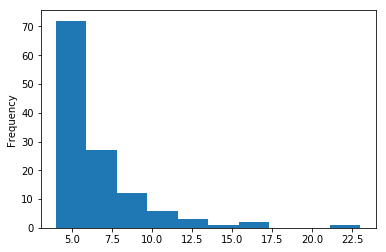

In [9]:
from pandas import Series
dist=[]
for cluster, ids in allClusterSeqIDs.iteritems():
    id_len = len(ids)
    if id_len > 3: dist.append(id_len)
dist = Series(dist)
dist.plot.hist();
    

In [11]:
tmpDict = {}
from pandas import Series
for id,seq in tracrSeqDict.iteritems(): tmpDict[id[:id.rfind("_")]]=seq
from Bio import pairwise2
for cluster, seqIDList in allClusters.iteritems():
    clusterFileName = "conseqs0/"+cluster.replace(" ","_")+".fasta"
    fh = open(clusterFileName,"wb")
    clusterStats = []
    for seqID in seqIDList: clusterStats.append(len(tmpDict[seqID]))
    clusterStats = Series(clusterStats)
    keepSeqs = clusterStats[~((clusterStats-clusterStats.mean()).abs() > clusterStats.std())]
    minSeq, maxSeq = keepSeqs.min(), keepSeqs.max()
    for seqID in seqIDList: 
        seqLen = len(tmpDict[seqID])
        if seqLen >= minSeq and seqLen <= maxSeq:fh.write(">%s\n%s\n" % (seqID,tmpDict[seqID]))
    fh.close()
    system("cd-hit-est -i %s -o %s_cluster -M 0 -d 0 -c .90 -T 0 -sc 1" % (clusterFileName,clusterFileName))
    keepers=set()
    clusterID = ""
    for line in open("%s_cluster.clstr" % (clusterFileName)):
        if ">Cluster" in line:
            if clusterID != "":break
            clusterID = line.strip().replace(">","")
            print cluster
        else:
            sequenceID = line[line.find(">")+1:line.find("...")] 
            keepers.add(sequenceID)
            print line.strip()
    system("rm %s*" % (clusterFileName))
    if len(keepers)==1: continue
    else:
        print clusterFileName,len(keepers),"/",len(seqIDList), clusterStats.std(), minSeq,"\n"
        fh = open(clusterFileName,"wb")
        for seqID in keepers: fh.write(">%s\n%s\n" % (seqID,tmpDict[seqID]))
        fh.close()

Cluster 468
0	93nt, >NZ_JVWD01000070.1_ORF1... *
1	92nt, >NZ_KV832038.1_ORF1... at -/96.74%
2	91nt, >NZ_LAWC01000001.1_ORF2... at +/96.70%
conseqs0/Cluster_468.fasta 3 / 10 102.518778768 91 

Cluster 5
0	79nt, >NZ_JMTN01000040.1_ORF1... at +/94.94%
1	185nt, >DBTQ01000004_ORF1... *
conseqs0/Cluster_5.fasta 2 / 14 75.2916673001 74 

Cluster 1251
0	92nt, >NZ_MCHW01000049.1_ORF1... at +/97.83%
1	92nt, >NZ_LXZW01000007.1_ORF1... at -/97.83%
2	93nt, >NZ_JVWD01000070.1_ORF1... *
3	90nt, >NZ_CP019935.1_ORF2... at -/98.89%
4	92nt, >NZ_PHHJ01000025.1_ORF1... at +/97.83%
5	92nt, >NZ_KV832038.1_ORF1... at -/96.74%
conseqs0/Cluster_1251.fasta 6 / 9 82.7392154772 60 

Cluster 504
0	147nt, >NZ_LSNG01000006.1_ORF1... at -/95.92%
1	148nt, >NZ_JVGG01000018.1_ORF1... *
conseqs0/Cluster_504.fasta 2 / 10 60.2004983368 138 

Cluster 508
0	91nt, >NZ_LAVZ01000010.1_ORF2... at -/94.51%
1	91nt, >NZ_JUTV01000160.1_ORF1... at +/95.60%
2	89nt, >NZ_JWGF01000054.1_ORF1... at +/93.26%
3	92nt, >NZ_LXZW01000007.1_ORF1.

In [18]:
import itertools
for cluster, ids in allClusters.iteritems():
    if len(ids)<=3:continue
    maxOverlap = 0
    for seq1, seq2 in itertools.combinations(ids, 2):
        maxOverlap = max(len(allClusterSeqIDs[seq1].intersection(allClusterSeqIDs[seq2])),maxOverlap)
    print cluster, "%i/%i" % (maxOverlap, len(ids))
        


Cluster 803 2 / 4
Cluster 483 3 / 14
Cluster 664 2 / 4
Cluster 256 2 / 11
Cluster 496 2 / 8
Cluster 478 2 / 5
Cluster 17 4 / 6
Cluster 894 2 / 8
Cluster 416 6 / 12
Cluster 1427 3 / 4
Cluster 1939 1 / 4
Cluster 683 4 / 6
Cluster 442 2 / 4
Cluster 1982 1 / 4
Cluster 1419 2 / 4
Cluster 699 4 / 5
Cluster 452 4 / 10
Cluster 6 3 / 40
Cluster 5 2 / 30
Cluster 2 5 / 7
Cluster 846 2 / 4
Cluster 992 2 / 4
Cluster 192 2 / 11
Cluster 1474 1 / 5
Cluster 727 1 / 8
Cluster 158 2 / 34
Cluster 710 1 / 5
Cluster 593 4 / 34
Cluster 1457 1 / 5
Cluster 145 3 / 4
Cluster 1326 3 / 4
Cluster 1199 3 / 4
Cluster 1442 2 / 14
Cluster 1680 3 / 10
Cluster 1531 2 / 5
Cluster 171 2 / 6
Cluster 81 3 / 5
Cluster 1051 1 / 5
Cluster 1832 1 / 5
Cluster 541 3 / 11
Cluster 91 4 / 47
Cluster 764 2 / 7
Cluster 1234 2 / 5
Cluster 1950 2 / 6
Cluster 975 4 / 4
Cluster 111 5 / 4
Cluster 119 4 / 6
Cluster 118 2 / 5
Cluster 1318 4 / 4
Cluster 49 1 / 9
Cluster 1492 2 / 4
Cluster 1568 2 / 7
Cluster 1563 2 / 4
Cluster 362 2 / 6
Cluste

In [13]:
len(allClusterSeqIDs.keys())

362

In [43]:
import pickle
pickle.dump(TreeColors,open("pickles/TreeColors.p","wb"))

In [ ]:
CasTree = AnnotateTree([],tree="Cas9-Like-clustered.faa.tree") #,colors=TreeColors)
CasTree.tree.render(file_name="%%inline", w=1000, tree_style=CasTree.ts) 

Number of leaves: 2670


In [13]:
for cluster, ids in allClusterSeqIDs.iteritems():
    print cluster
    num=0
    for id in ids:
        num+=1
        print "\t%i. %s" % (num,id)

Cluster 936
	1. NZ_FYDB01000008.1_ORF1
	2. NZ_JRWE01000053.1_ORF1
	3. PABT01000022_ORF1
Cluster 803
	1. NZ_BEWZ01000027.1_ORF1
	2. NZ_PKID01000005.1_ORF1
	3. NZ_PNGD01000017.1_ORF1
	4. NZ_NCVG01000019.1_ORF2
Cluster 799
	1. NZ_AUKZ01000017.1_ORF1
	2. NZ_JPFU01000002.1_ORF1
	3. NZ_GL732492.1_ORF1
Cluster 483
	1. NZ_AJKQ01000017.1_ORF1
	2. NZ_JVWP01000001.1_ORF1
	3. NZ_GL732470.1_ORF1
	4. NZ_NCUH01000007.1_ORF1
	5. NZ_NCUF01000007.1_ORF1
	6. NZ_NCUC01000010.1_ORF1
	7. NZ_KV832087.1_ORF1
	8. NZ_NCUE01000015.1_ORF1
	9. NZ_JYGU01000007.1_ORF1
	10. NZ_ALJN01000008.1_ORF1
	11. NZ_NCUP01000005.1_ORF2
	12. NZ_LNVH01000012.1_ORF1
	13. NZ_LVJM01000010.1_ORF1
	14. NZ_PKIF01000003.1_ORF1
Cluster 664
	1. BBPW01000006_ORF1
	2. NZ_AJGU01000019.1_ORF1
	3. DGUJ01000289_ORF1
	4. LVBI01000042_ORF2
Cluster 1435
	1. NZ_JRJB01000004.1_ORF1
	2. NZ_KQ033871.1_ORF2
	3. NZ_KQ034019.1_ORF1
Cluster 256
	1. AFFO01000009_ORF1
	2. NZ_JYGN01000007.1_ORF2
	3. NZ_LAWN01000002.1_ORF1
	4. NZ_KQ969342.1_ORF1
	5. NZ_LAWJ010

In [4]:
from Bio.SeqIO import parse, write
casRelatedAssemblies = {}
for id in allCas9s:
    seqID = id[:id.rfind("_")]
    for rec in parse("assemblies/%s.fasta" % id,"fasta"):
        if rec.id == seqID:
#             with open("assemblies/%s.fa" % id, "wb") as fh:
#                 write([rec],fh,"fasta") 
            casRelatedAssemblies[id]=str(rec.seq)
            break

In [5]:
fh = open("casRelatedAssemblies.fasta","wb")
for id,seq in casRelatedAssemblies.iteritems(): fh.write(">%s\n%s\n" % (id,seq))
fh.close()

In [ ]:
numPos
numTerminators
tracrSeqDict

In [17]:
newSolutions

{}

In [14]:
%%bash
mkdir tmp
ls -l 

total 95538
drwx--s--x 2 dooleys1 germs     2672 Jun 27 15:34 assemblies
-rw-r--r-- 1 dooleys1 germs  3388226 Jul  6 17:13 Cas9-Like-clustered.faa
-rw-r--r-- 1 dooleys1 germs   611108 Jul  6 17:13 Cas9-Like-clustered.faa.clstr
-rw-r--r-- 1 dooleys1 germs 17415584 Jul  6 17:13 Cas9-Like.faa
-rw-r--r-- 1 dooleys1 germs        0 Jul  6 18:06 Crispr_results_2018.tsv
drwx--s--x 2 dooleys1 germs     5342 Jul  6 20:37 crisprs
drwx--s--x 2 dooleys1 germs        3 Jun 27 17:17 crisprs2
drwx--s--x 7 dooleys1 germs       12 Jul  6 17:03 diverseCas9s
-rw-r--r-- 1 dooleys1 germs   379734 Jul  6 16:44 DiverseCas9s.aln
-rw-r--r-- 1 dooleys1 germs   122512 Jul  6 16:25 DiverseCas9s.faa
-rw------- 1 dooleys1 germs    18339 Jul  6 16:44 DiverseCas9s.faa.tree
-rw-r--r-- 1 dooleys1 germs   480438 Jul  6 16:44 DiverseCas9s.hmm
drwx--s--x 2 dooleys1 germs       22 Jun 29 15:38 domains
drwx--s--x 3 dooleys1 germs   222460 Jun  6 13:38 hmmSearch
drwx--s--x 2 dooleys1 germs      113 Jul  6 18:01 logs
drwxr-sr-

In [ ]:
################### ARTIFACTS BELOW ###########################
clusterSizes = []
index = 0
colors = {
    0:"#C0C0C0", 1:"#808080",
    2:"#FF0000", 3:"#800000",
    4:"#FFFF00", 5:"#808000",
    6:"#00FF00", 7:"#008000",
    8:"#00FFFF", 9:"#008080",
    10:"#0000FF", 11:"#000080",
    12:"#FF00FF", 13:"#800080",
    14:"#DAF7A6", 15:"#FF5733",
    16:"#C70039", 17:"#900C3F",
    18:"#900C3F", 19:"#900C3F",
    20:"#900C3F", 21:"#900C3F",
    22:"#900C3F", 23:"#900C3F",
    24:"#900C3F", 25:"#900C3F",
    26:"#900C3F", 27:"#900C3F"
}
# for cluster in allClusters: 
#     clusterSizes.append(len(allClusterSeqIDs[cluster]))
#     if len(allClusterSeqIDs[cluster])>=3: 
#         fh = open("data/%s.fa" %(cluster.replace(" ","_")),"w")
#         for id in allClusters[cluster]: 
#             fh.write(">%s\n%s\n" % (id,tracrSeqDict[id]))
#             #TreeColors[id[:id.find("_")]] = colors[index]
#             print id[:id.find("_")],
#         print
#         index += 1
#         fh.close()
#     print "data/%s.fa" % (cluster.replace(" ","_"))
# print "# indices needed:", index-1
# ser = Series(clusterSizes)
# ser.plot.hist()
# print ser.describe() 